In [1]:
%cd C:/Users/shree/0last/data

C:\Users\shree\0last\data


In [2]:
#import zipfile

In [3]:
#with zipfile.ZipFile('C:/Users/shree/0last/words.zip', 'r') as zip_ref:
#        zip_ref.extractall('C:/Users/shree/0last/data')

In [2]:
with open('C:/Users/shree/0last/data/words.txt','r') as f:
    for i in range(50):
        line = f.readline()
        print(line)

#--- words.txt ---------------------------------------------------------------#

#

# iam database word information

#

# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

#

#     a01-000u-00-00  -> word id for line 00 in form a01-000u

#     ok              -> result of word segmentation

#                            ok: word was correctly

#                            er: segmentation of word can be bad

#

#     154             -> graylevel to binarize the line containing this word

#     1               -> number of components for this word

#     408 768 27 51   -> bounding box around this word in x,y,w,h format

#     AT              -> the grammatical tag for this word, see the

#                        file tagset.txt for an explanation

#     A               -> the transcription for this word

#

a01-000u-00-00 ok 154 408 768 27 51 AT A

a01-000u-00-01 ok 154 507 766 213 48 NN MOVE

a01-000u-00-02 ok 154 796 764 70 50 TO to

a01-000u-00-03 ok 154 919 757 166 78 VB stop

a01

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
base_path = "C:/Users/shree/0last/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples

)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [6]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [8]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [10]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [11]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [12]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

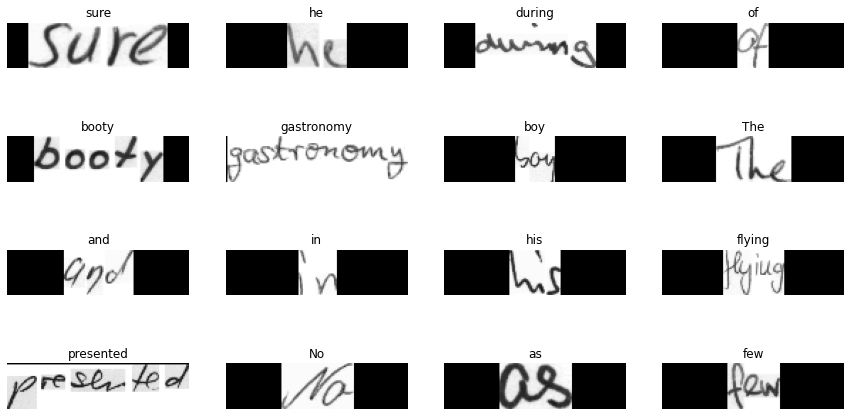

In [13]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [14]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [15]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [18]:
# model training

In [19]:
"""
epochs = 12  # To get good results this should be at least 50.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("handwriting.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb,early_stopping_cb,edit_distance_callback],
)
"""

'\nepochs = 12  # To get good results this should be at least 50.\ncheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("handwriting.h5", save_best_only=True)\n\nearly_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor=\'val_loss\',restore_best_weights=True)\n\nmodel = build_model()\nprediction_model = keras.models.Model(\n    model.get_layer(name="image").input, model.get_layer(name="dense2").output\n)\nedit_distance_callback = EditDistanceCallback(prediction_model)\n\n# Train the model.\nhistory = model.fit(\n    train_ds,\n    validation_data=validation_ds,\n    epochs=epochs,\n    callbacks=[checkpoint_cb,early_stopping_cb,edit_distance_callback],\n)\n'

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Define the CTCLayer as a custom layer
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Load the model with the custom CTCLayer
with tf.keras.utils.custom_object_scope({'CTCLayer': CTCLayer}):
    new_model = tf.keras.models.load_model('C:/Users/shree/0last/handwriting.h5')

# Show the model architecture
new_model.summary()


Model: "digitizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 128, 32, 128  36992       ['Conv1[0][0]']                  
                                )                                                                 
                                                                                          

In [17]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

len is :  2
batch img shape:  (128, 32, 1)
2/2 [==============================] - 8s 2s/step
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)


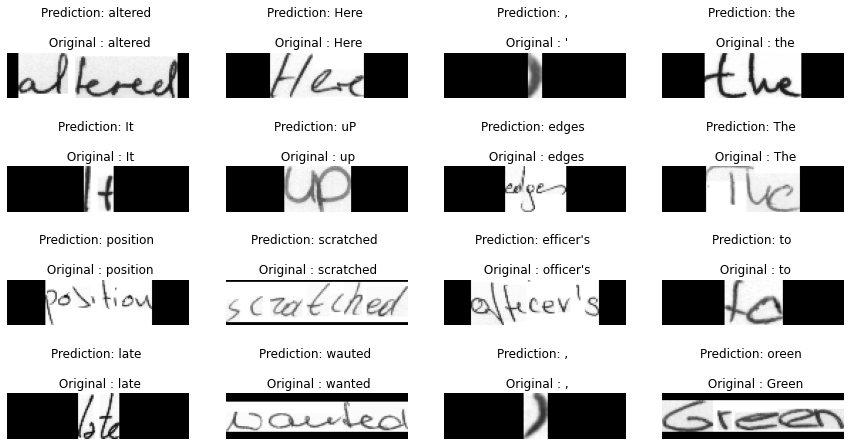

In [18]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        print(img.shape)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()


In [24]:
# Precision
"""
total_count = 0
correct_count = 0

for batch in test_ds.take(75):
    batch_images,batch_labels = batch["image"],batch["label"]

    
    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)

    for i in range(64):
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")


        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        total_count = total_count+1
        if(label == pred_texts[i]):
          correct_count = correct_count+1 


print("Total count : ",total_count)

print("Correct count : ",correct_count)

percentage = (correct_count/total_count)*100
print(f"Percentage : {percentage}% .")
"""

2/2 [==============================] - 8s 4s/step
Total count :  4800
Correct count :  3789
Percentage : 78.9375% .


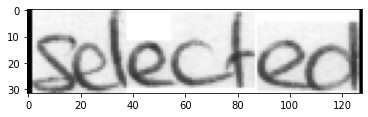

(32, 128)


In [22]:
"""
## custom image
img_path = "C:/Users/shree/0last/sampleimg.png"
image2 = preprocess_image(img_path)
# label = vectorize_label(label)
img2 = tf.image.flip_left_right(image2)
img2 = tf.transpose(img2, perm=[1, 0, 2])
img2 = (img2 * 255.0).numpy().clip(0, 255).astype(np.uint8)
img2 = img2[:, :, 0]
plt.imshow(img2,cmap="gray")
plt.show()
img_list = [img2]
print(img2.shape)
# gathering text
# preds2 = prediction_model.predict(img_list)
# pred_texts2 = decode_batch_predictions(preds2)
# print(pred_texts2)
"""

In [19]:

def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [26]:
"""
img_paths_3 = ["C:/Users/shree/0last/newimg.png","C:/Users/shree/0last/sampleimg2.png","C:/Users/shree/0last/sampleimg3.png","C:/Users/shree/0last/sampleimg4.png","C:/Users/shree/0last/sampleimg5.png"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds
"""

<PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

len is :  5
batch img shape:  (128, 32, 1)
1/1 [==============================] - 6s 6s/step
['handuriting', 'differed', 'scope', 'there', 'his']


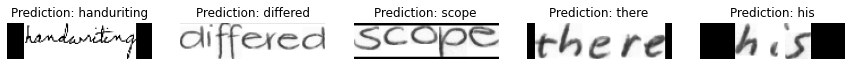

In [27]:
"""
for batch in custom_ds.take(1):
    MAX_LABEL_LENGTH=21
    batch_images = tf.stack(batch)
    batch_labels = tf.zeros([batch_images.shape[0], MAX_LABEL_LENGTH])
    
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[0].shape)
    
    _, ax = plt.subplots(1, 5, figsize=(15, 8))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)
    
    
    print(pred_texts)

    for i in range(5):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()
"""

In [ ]:
#experimenting

In [25]:
#import cv2

In [26]:
"""
def prescription_out(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.figure()
    
    def thresholding(image):
        img_gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret,thresh=cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
        plt.imshow(thresh,cmap='gray')
        return thresh
    thresh_img=thresholding(img)

#To detect individual lines for segmentating the word
    kernel=np.ones((3,85),np.uint8)
    dilated=cv2.dilate(thresh_img,kernel,iterations=1)
    plt.imshow(dilated,cmap='gray')
    plt.figure()
    (contours,heiarchy)=cv2.findContours(dilated.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines=sorted(contours, key=lambda ctr:cv2.boundingRect(ctr)[1]) 
#(1=SOrting Vertically,0=Sorting Horizontally)


    img2=img.copy()
    for ctr in sorted_contours_lines:
        x,y,w,h=cv2.boundingRect(ctr)
        cv2.rectangle(img2,(x,y),(x+w,y+h),(0,0,255),2)
    plt.imshow(img2)
    plt.figure()


    kernel=np.ones((3,15),np.uint8)
    dilated=cv2.dilate(thresh_img
                       ,kernel,iterations=1)
    plt.imshow(dilated,cmap='gray')
    plt.figure()

    img3=img.copy()
    word_list=[]
    for line in sorted_contours_lines:
        x,y,w,h=cv2.boundingRect(line)
        #Finding ROI of each line
        roi_line=dilated[y:y+w,x:x+w]
        #Drawing Contours on each word
        (cnt,heiarchy)=cv2.findContours(roi_line.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        sorted_contours_lines=sorted(cnt, key=lambda cntr:cv2.boundingRect(cntr)[0])
    
        for word in sorted_contours_lines:
            if cv2.contourArea(word)<100:
                continue
            x2,y2,w2,h2=cv2.boundingRect(word)
            word_list.append([x+x2,y+y2,x+x2+w2,y+y2+h2])
            cv2.rectangle(img3,(x+x2,y+y2),(x+x2+w2,y+y2+h2),(255,0,0),2)

    plt.imshow(img3)
    plt.figure()
    return word_list
"""

In [27]:
"""
def prescription_resultword(path):
    word_list=prescription_out(path)
    img=cv2.imread(path)
    os.mkdir('./segout9')
    count=0
    li=[]
    for i in word_list:
    
        word=i
        roi_17=img[word[1]:word[3],word[0]:word[2]]
        cv2.imwrite(os.path.join('./segout1',str(count)+'.jpg'),roi_17)
        count=count+1
        plt.imshow(roi_17)
        plt.figure()
    import glob
    for i in glob.glob('./segout9/*'):
        li.append(output(i))
    return li
"""

C:\Users\shree\AppData\Local\Temp/ipykernel_8836/2105536736.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[]

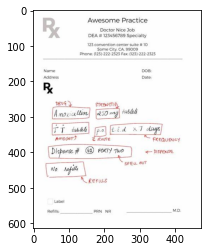

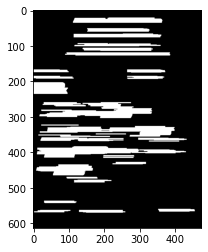

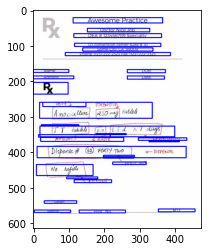

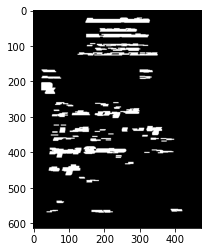

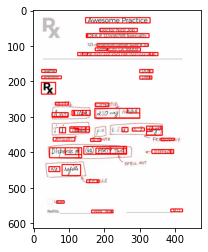

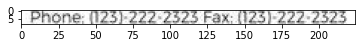

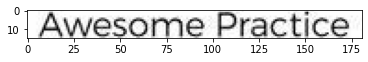

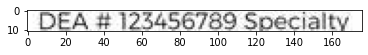

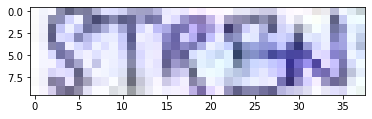

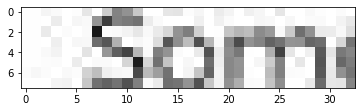

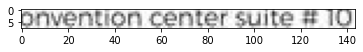

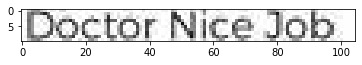

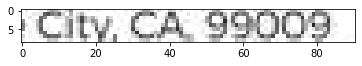

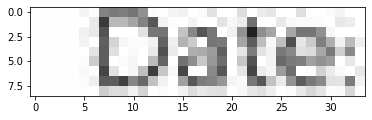

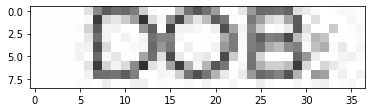

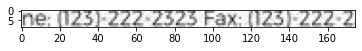

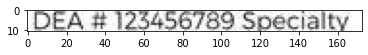

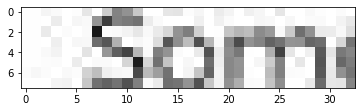

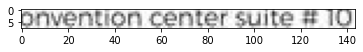

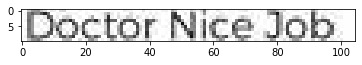

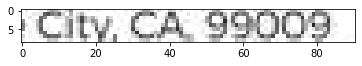

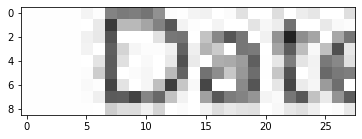

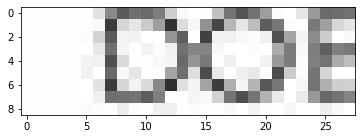

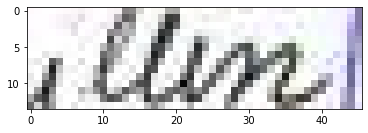

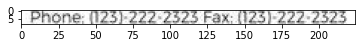

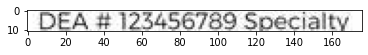

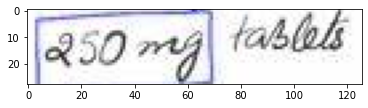

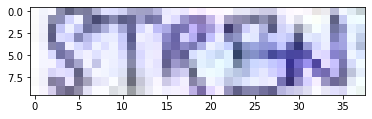

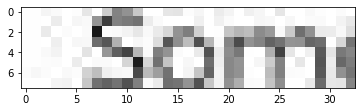

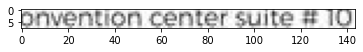

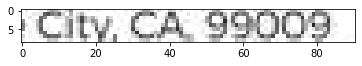

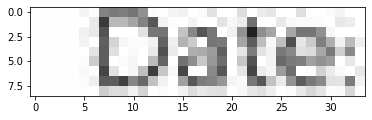

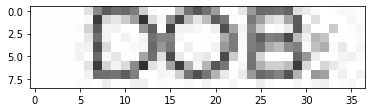

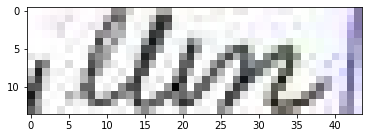

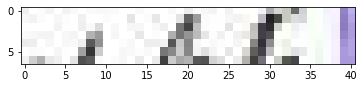

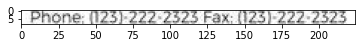

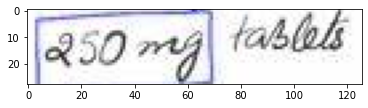

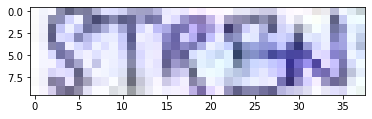

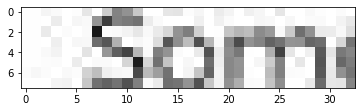

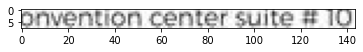

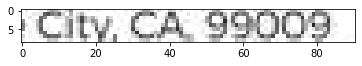

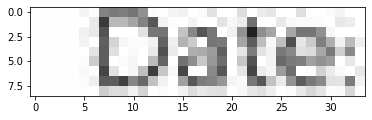

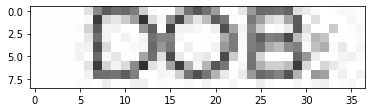

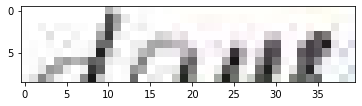

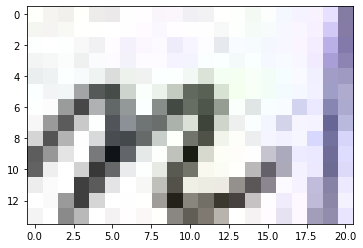

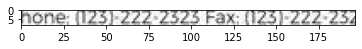

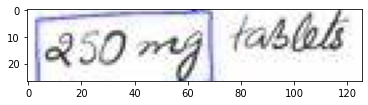

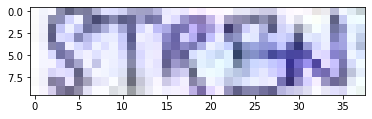

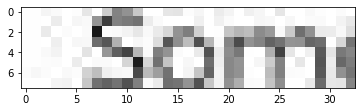

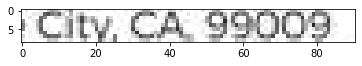

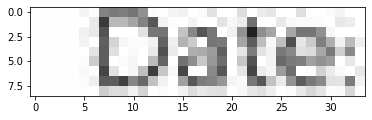

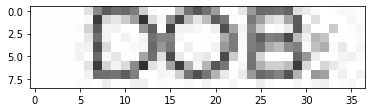

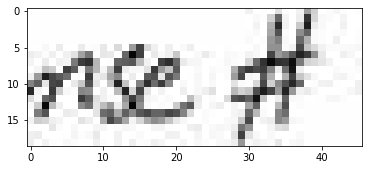

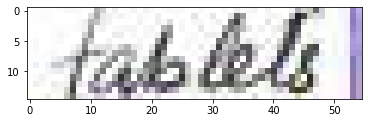

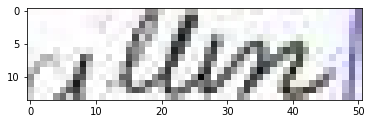

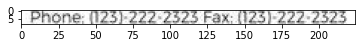

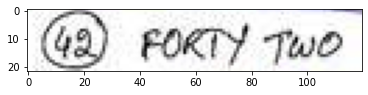

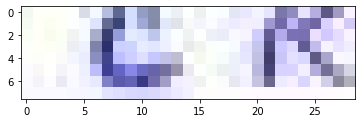

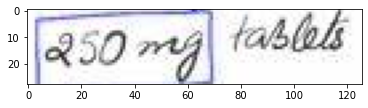

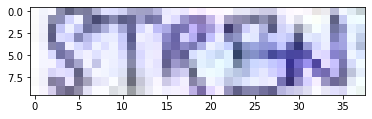

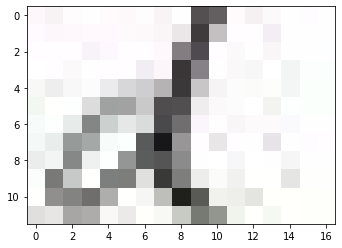

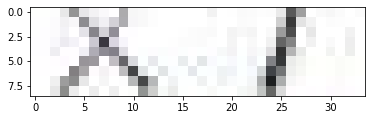

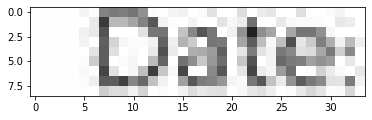

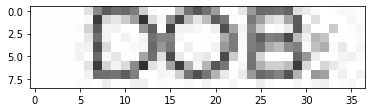

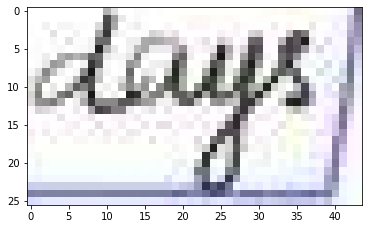

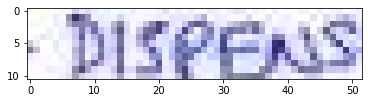

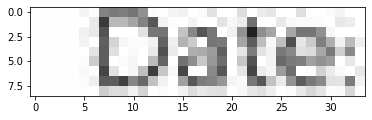

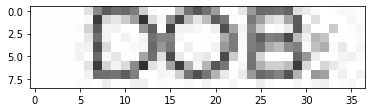

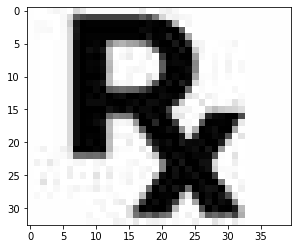

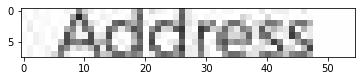

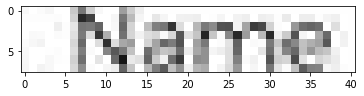

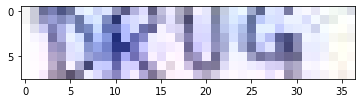

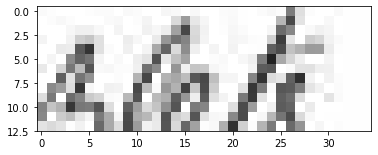

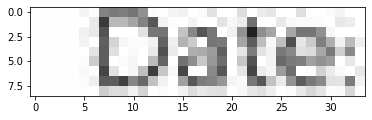

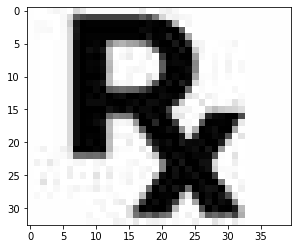

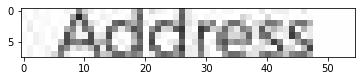

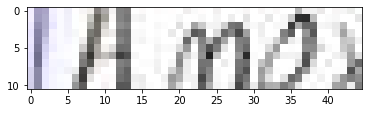

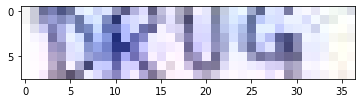

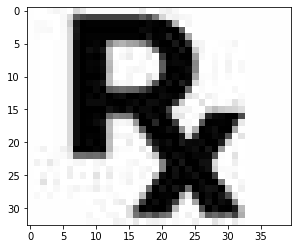

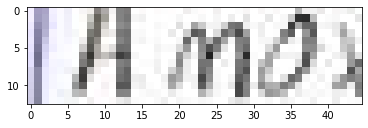

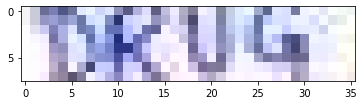

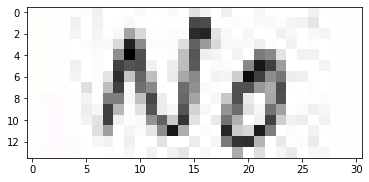

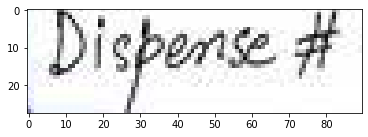

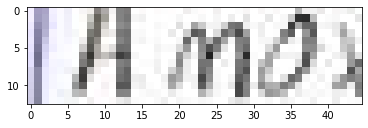

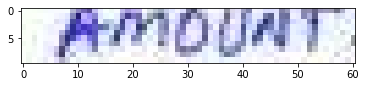

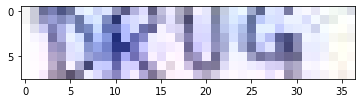

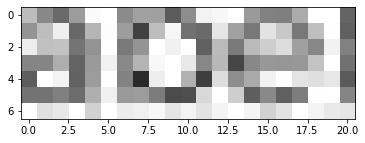

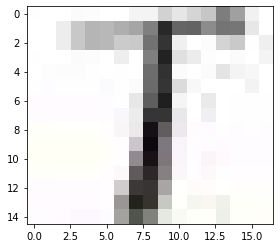

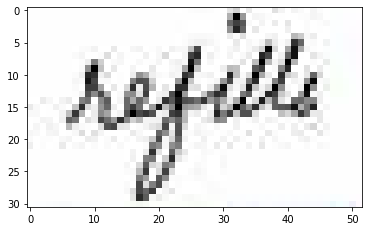

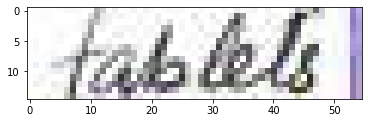

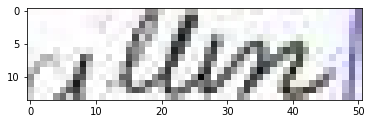

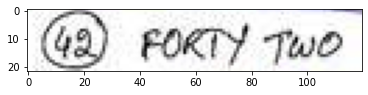

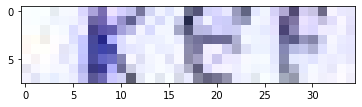

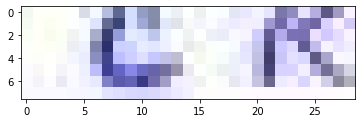

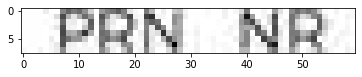

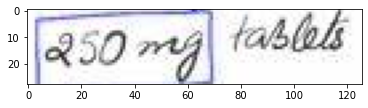

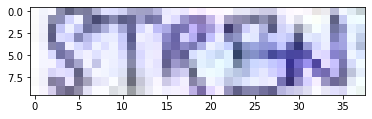

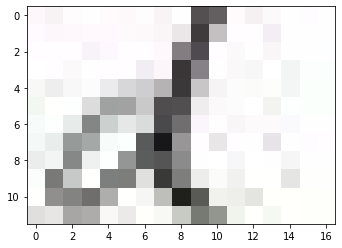

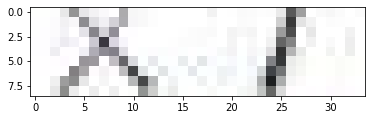

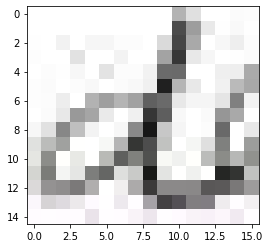

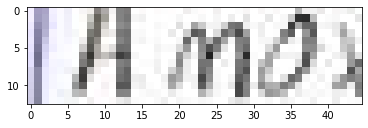

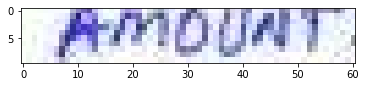

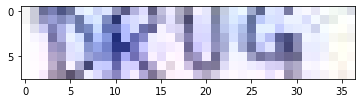

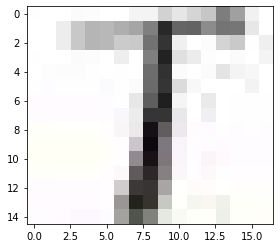

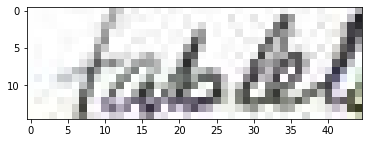

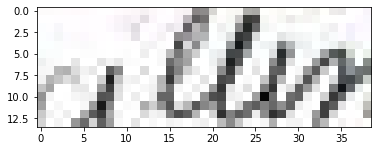

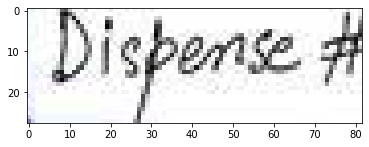

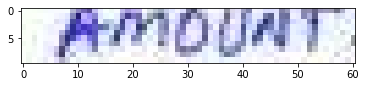

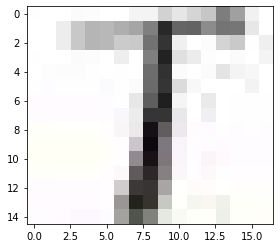

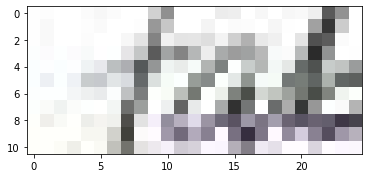

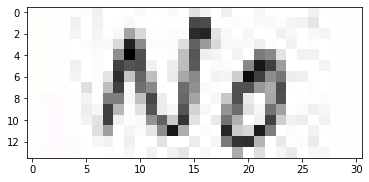

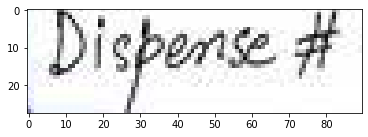

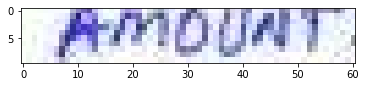

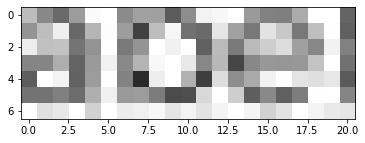

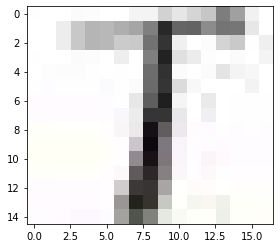

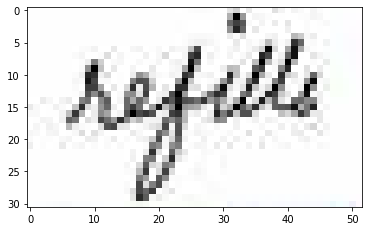

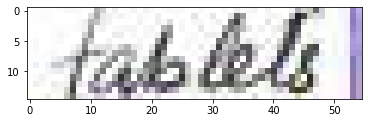

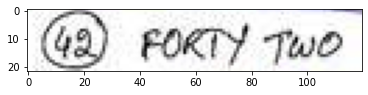

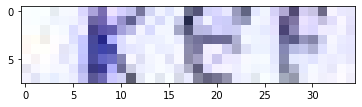

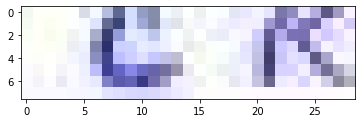

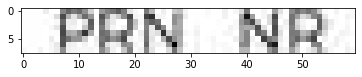

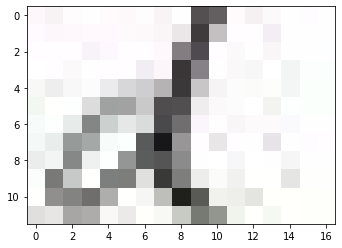

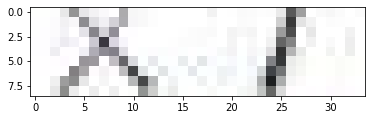

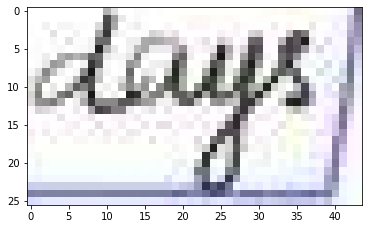

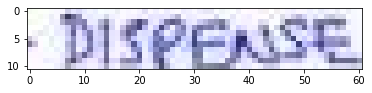

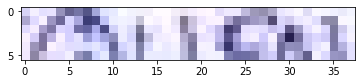

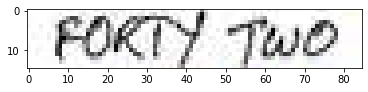

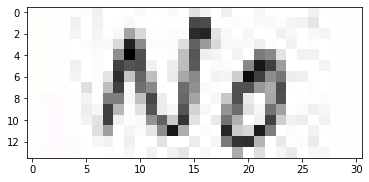

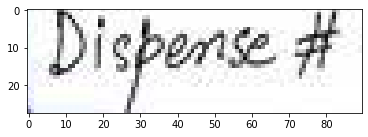

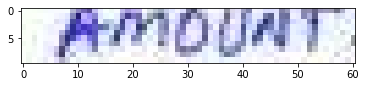

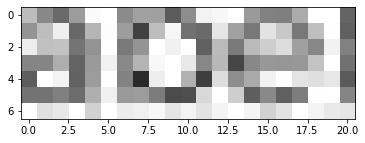

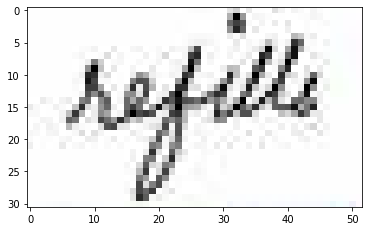

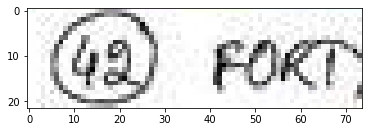

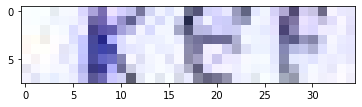

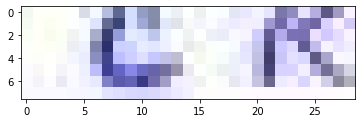

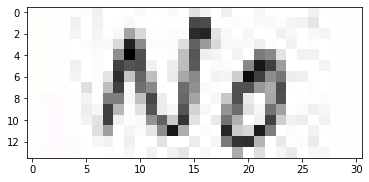

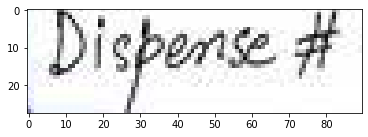

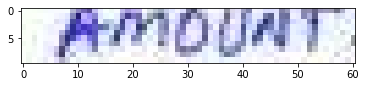

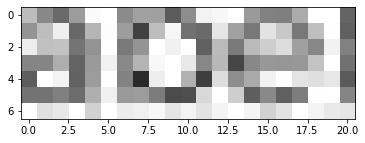

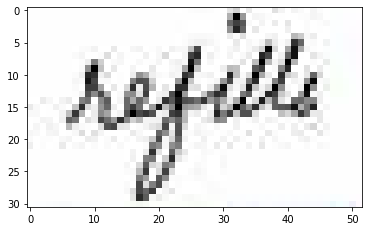

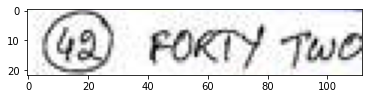

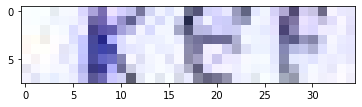

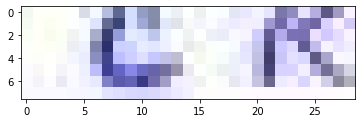

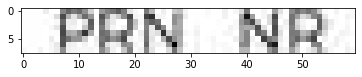

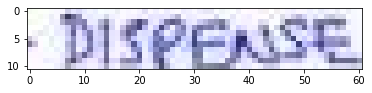

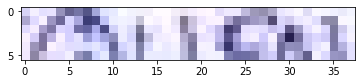

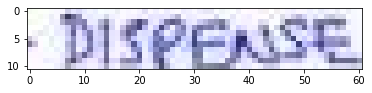

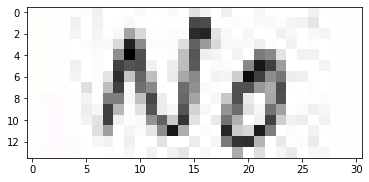

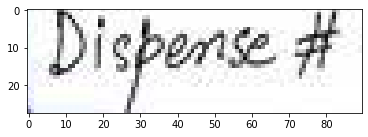

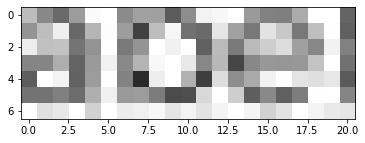

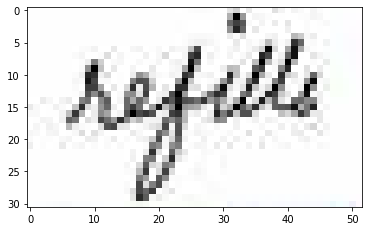

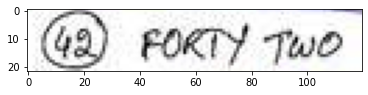

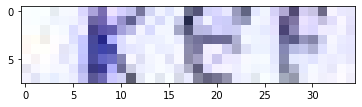

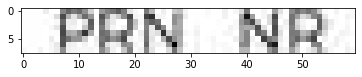

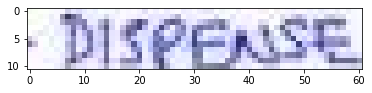

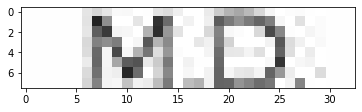

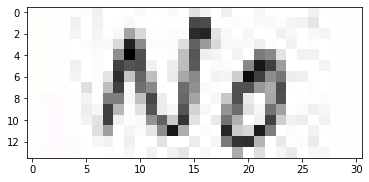

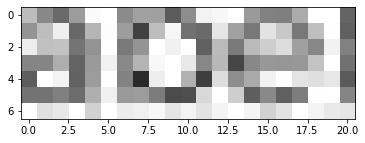

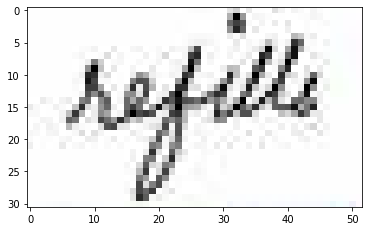

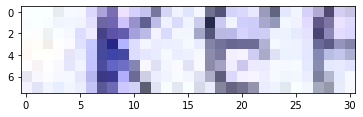

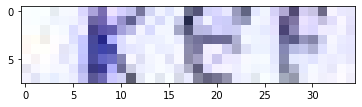

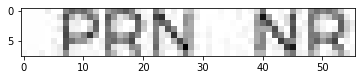

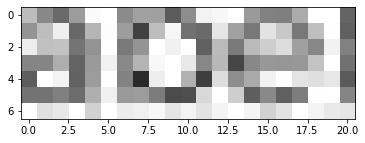

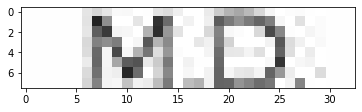

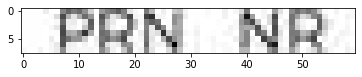

<Figure size 432x288 with 0 Axes>

In [78]:
#prescription_resultword('C:/Users/shree/0last/prescription.jpeg')

In [ ]:
#last

In [23]:
"""
import cv2

# read in prescription image
image = cv2.imread("C:/Users/shree/0last/prescript.jpg")

# convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# dilate image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilated = cv2.dilate(thresh, kernel, iterations=5)

# find contours in dilated image
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# initialize empty list to store output image paths
output_image_paths = []

# loop through contours and extract bounding boxes
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    
    # crop corresponding region of original image
    word_image = image[y:y+h, x:x+w]
    
    # generate output image path and save image to disk
    output_image_path = "C:/Users/shree/0last/output/{}.png".format(x)
    cv2.imwrite(output_image_path, word_image)
    
    # append output image path to list
    output_image_paths.append(output_image_path)
    
print(output_image_paths)
"""

['C:/Users/shree/0last/output/84.png', 'C:/Users/shree/0last/output/279.png', 'C:/Users/shree/0last/output/223.png', 'C:/Users/shree/0last/output/136.png', 'C:/Users/shree/0last/output/309.png', 'C:/Users/shree/0last/output/269.png', 'C:/Users/shree/0last/output/132.png', 'C:/Users/shree/0last/output/298.png', 'C:/Users/shree/0last/output/345.png', 'C:/Users/shree/0last/output/358.png', 'C:/Users/shree/0last/output/125.png', 'C:/Users/shree/0last/output/291.png', 'C:/Users/shree/0last/output/211.png', 'C:/Users/shree/0last/output/123.png', 'C:/Users/shree/0last/output/304.png', 'C:/Users/shree/0last/output/102.png', 'C:/Users/shree/0last/output/97.png', 'C:/Users/shree/0last/output/210.png']


In [24]:
"""
def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)
"""

In [25]:
"""
custom_ds = prepare_dataset_custom(output_image_paths)
custom_ds
"""

<PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

len is :  18
batch img shape:  (128, 32, 1)
1/1 [==============================] - 7s 7s/step
['instimerorsisor', 'Rszaindebree', 'song-', 'oxprelol', 'tabat', 'Ti?', 'linetilineso', 'Bifaisopol', ',', 'tabl', 'Porolanilun', ',', 'Reiango', 'Betalor', 'tabl', 'B', 'misfesfieeciss', 'Wimsigilfissicanne']


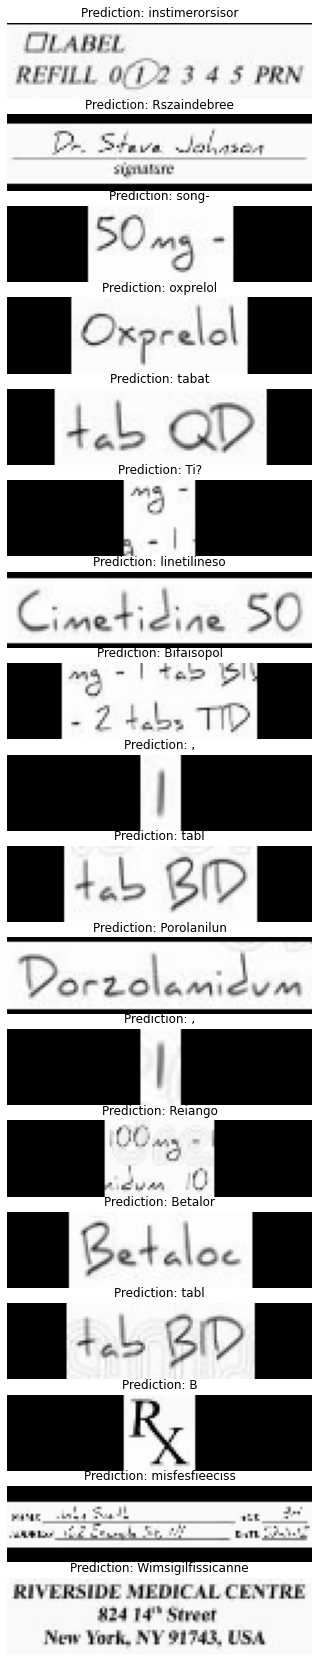

In [26]:
"""
for batch in custom_ds.take(1):
    MAX_LABEL_LENGTH=21
    batch_images = tf.stack(batch)
    batch_labels = tf.zeros([batch_images.shape[0], MAX_LABEL_LENGTH])
    
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[0].shape)
    
    _, ax = plt.subplots(len(batch), 1, figsize=(30, 30))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)
    
    
    print(pred_texts)

        
    for i in range(len(batch)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")



plt.show()
"""